# Predicting Electricity Prices in a District: A Time Series Analysis with Facebook Prophet
### By: ChristianTan_PH

Hello everyone! 

My name is Tan. I'm an intern at Hamoye Data Science Internship and today I'll be exploring time series modelling using Prophet. I'll be using a dataset of electricity prices and showing you how to prepare the data, create a Prophet model, and evaluate its performance.

Throughout this notebook, I'll be sharing my thought process and the steps I take in applying the concepts I've learned about time series modelling using Prophet. 

I will begin our journey by focusing on **univariate time-series modelling** and then proceed to cover **multivariate time-series modelling**.

Since I'm learning about this for the first time, I'm eager to share my experiences and what I've discovered along the way. By the end of this notebook, we'll both have a better understanding of how to implement time series modelling in our own projects.

So let's get started!


## About The Dataset

The archive contains 92,016 measurements of electricity data gathered between September 2010 and February 2021.

Here's the link to access the dataste: https://github.com/HamoyeHQ/HDSC-Time-series-analysis-and-forecast

**Notes:**

1. The dataset is sampled on an hourly basis. It has the following features:

**Attribute Information:**

**FullDate:** Date in format yyyy-mm-dd  hh:mm:ss<br>
**ElecPrice:** Prices of electricity charged in Kw per hour<br>
**Gas Price:** power generated was done via a gas power plant, gas price is the price of gas at time-T<br>
**SysLoad:** Total Load on system or Power consumed at time-T <br>
**Tmax:** maximum temperature at time-T


# PART I. UNIVARIATE TIME-SERIES FORECASTING

# Initial Data Preparation and Exploration



## Installing & importing the necessary packages

In [1]:
# Install Prophet

!pip install prophet

In [1]:
# Import necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from prophet import Prophet


c:\Users\Andreas\anaconda3\envs\esl\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Loading the dataset

In [2]:
# Load the Dataset and check its head, tail & shape

df = pd.read_csv('./Time_series_analysis_and_forecast_DATASET.csv')

print('::HEAD::', df.head())

print('::TAIL::', df.tail())
print('::SHAPE::', df.shape)

::HEAD::               FullDate  Tmax   SysLoad  GasPrice  ElecPrice
0  2010-09-01 00:00:00  15.8  1688.215      3.69     23.710
1  2010-09-01 01:00:00  15.8  1669.195      3.69     22.635
2  2010-09-01 02:00:00  15.8  1491.980      3.69     22.565
3  2010-09-01 03:00:00  15.8  1330.760      3.69     18.910
4  2010-09-01 04:00:00  15.8  1247.940      3.69     18.030
::TAIL::                   FullDate  Tmax    SysLoad  GasPrice  ElecPrice
92011  2021-02-28 19:00:00  24.3  449.63625    5.4848    117.925
92012  2021-02-28 20:00:00  24.3  815.59975    5.4848     87.880
92013  2021-02-28 21:00:00  24.3  745.12325    5.4848     62.060
92014  2021-02-28 22:00:00  24.3  694.95150    5.4848     62.000
92015  2021-02-28 23:00:00  24.3  714.69630    5.4848     62.955
::SHAPE:: (92016, 5)


## Formatting the date

We now convert the FullDate column to datetime format using the to_datetime() function. This is important because Prophet requires the time series data to be in datetime format.

In [3]:
df['FullDate'] = pd.to_datetime(df['FullDate'])

In [4]:
df['FullDate']

0       2010-09-01 00:00:00
1       2010-09-01 01:00:00
2       2010-09-01 02:00:00
3       2010-09-01 03:00:00
4       2010-09-01 04:00:00
                ...        
92011   2021-02-28 19:00:00
92012   2021-02-28 20:00:00
92013   2021-02-28 21:00:00
92014   2021-02-28 22:00:00
92015   2021-02-28 23:00:00
Name: FullDate, Length: 92016, dtype: datetime64[ns]

## Decomposing the series

The purpose of decomposing a time-series dataset is to analyze and understand the underlying patterns and trends present in the data. This process involves breaking down the time-series into its component parts, such as trend, seasonality, and residuals. This can help in identifying the cause of fluctuations in the data and aid in forecasting future trends.

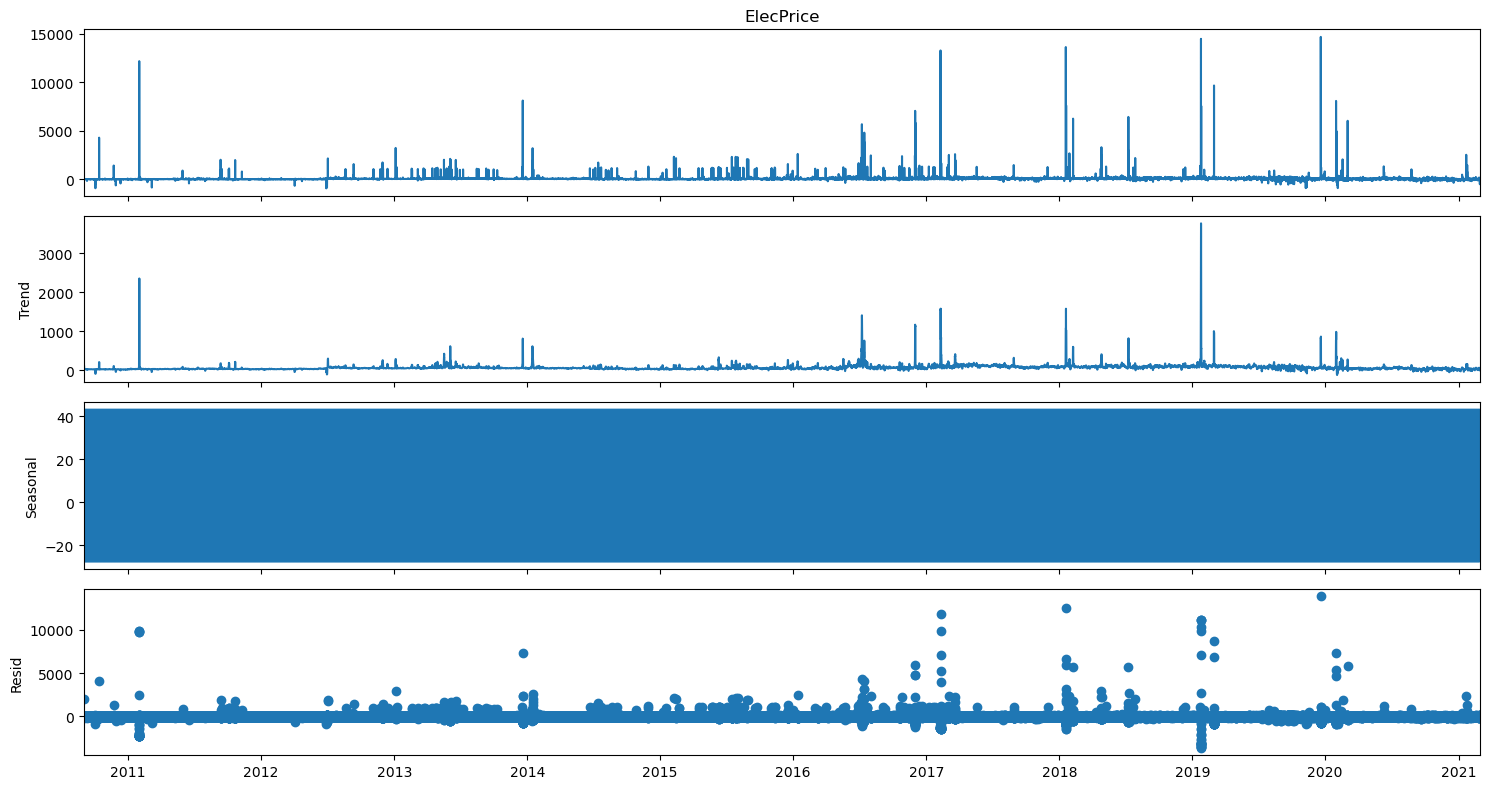

In [7]:
# Importing the required libraries for statistical modeling and visualization
import statsmodels.api as sm
from pylab import rcParams

# Creating a copy of the original dataframe
df_explore = df.copy()

# Setting the FullDate column as the index of the new dataframe
df_explore.set_index("FullDate", inplace=True)

# Setting the size of the plot figure
rcParams['figure.figsize'] = 15, 8

# Decomposing the time-series data in the ElecPrice column of the new dataframe
decompose_series = sm.tsa.seasonal_decompose(df_explore['ElecPrice'], model='additive')

# Plotting the decomposition results
decompose_series.plot()

# Displaying the plot
plt.show()



In this code, the seasonal decomposition is performed using an additive model, which assumes that the seasonal and residual components are added to the trend component to form the final time-series. 

Unfortunately, the dataset appears very noisy in this view. Let's continue exploring further.

## Applying the ADF test

The purpose of the **Augmented Dickey-Fuller (ADF) test** is to determine whether a time series is stationary or not. In other words, it is used to test the null hypothesis that a time series has a unit root, meaning that it is non-stationary and has a time-dependent structure. The ADF test statistic is calculated and compared to a critical value to determine if the series is stationary or not. If the test statistic is lower than the critical value, it can be concluded that the series is stationary and suitable for further analysis, such as ARIMA or SARIMA modeling.


**A stationary time series is important** in time series analysis because it has consistent statistical properties over time. This means that the mean, variance, and covariance are constant over time, making it easier to model and make predictions. On the other hand, a non-stationary time series has properties that change over time, making it difficult to model and make predictions.

**If a time series is found to be non-stationary**, it must be transformed to make it stationary before modeling. This can be achieved through techniques such as differencing or decomposition, which can remove the trend and seasonality from the series, making it stationary. Once the series is stationary, it can be used for further analysis such as ARIMA or SARIMA modeling, which require a stationary series to make accurate predictions.

In [8]:
# Import the ADF test function from the statsmodels library
from statsmodels.tsa.stattools import adfuller

# Apply the ADF test to the ElecPrice column of the dataframe
adf_result = adfuller(df['ElecPrice'])

# Print the results of the ADF test
print("ADF Statistic: {}".format(adf_result[0]))
print("p-value: {}".format(adf_result[1]))
print("No. of lags used: {}".format(adf_result[2]))
print("No. of observations used: {}".format(adf_result[3]))
print("Critical Values:")
for key, value in adf_result[4].items():
    print("\t{}: {}".format(key, value))


ADF Statistic: -31.95297569955783
p-value: 0.0
No. of lags used: 53
No. of observations used: 91962
Critical Values:
	1%: -3.430421110703783
	5%: -2.8615714297867108
	10%: -2.56678672898094


Based on the results of the ADF test, the time series dataset is stationary. The ADF statistic of -31.95 is significantly lower than the critical values at all confidence levels (1%, 5%, and 10%). The p-value is 0, which means that there is strong evidence against the hypothesis of non-stationarity. **Therefore, it can be concluded that the time series is stationary.**

## Initial visualization

Let us visualize the dataset to determine its stationarity and get an idea of our target accuracy.

### Visualizing Log Transformed Dataset

Let's observe its stationarity.

Let's apply log transformation to the dataset in order to reduce the scale of values and make it easier to detect trends and seasonality. By taking the difference with a period of 1, the trend and seasonality are removed from the series. The rolling mean is then computed to provide a smooth representation of the series and highlight any patterns that may exist in the data. The red line represents this rolling mean and serves as a tool for identifying patterns in the data.

c:\Users\Andreas\anaconda3\envs\esl\Lib\site-packages\pandas\core\internals\blocks.py:393: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
c:\Users\Andreas\anaconda3\envs\esl\Lib\site-packages\pandas\core\internals\blocks.py:393: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)


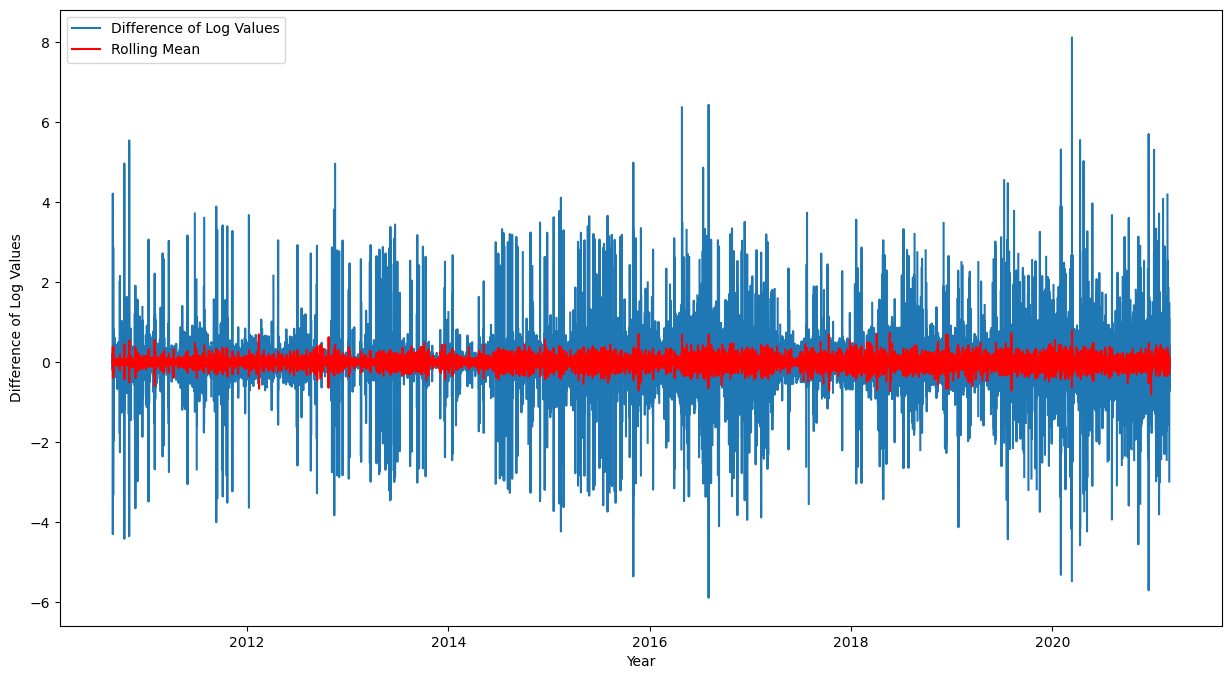

In [8]:
# Convert the original dataset into log values
df_log = np.log(df_explore)

# Calculate the difference of log values with a period of 1
df_diff = df_log.diff(periods= 1 )

# Plot the difference of log values and its rolling mean
plt.plot(df_diff.index, df_diff.ElecPrice, '-' )
plt.plot(df_diff.rolling( 12 ).mean(), color= 'red' )

# Provide a legend and label the axes
plt.legend(['Difference of Log Values', 'Rolling Mean'])
plt.xlabel('Year')
plt.ylabel('Difference of Log Values')

# Show the plot
plt.show()

Although the seasonality and trends are not obvious, we can still see that the series is stationary. This suggests that the ElecPrice values are relatively consistent within a certain range.

### Plotting Autocorrelation and Partial Autocorrelation Functions

Let's get an idea of our target accuracy

To provides valuable insights into the autocorrelation and partial autocorrelation of the time-series dataset, **the Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF)** are key components in time-series analysis and provide information about the relationships between observations at different time lags. By plotting the ACF and PACF, we can determine the order of the Autoregressive (AR) and Moving Average (MA) terms in an ARIMA or SARIMA model, which can help improve the accuracy of our predictions.

**AR models** are used when the current value of a time series is a linear combination of its past values. It assumes that past values have a direct effect on the current value. The number of past values used to predict the current value is called the order of the AR model.

On the other hand, **MA models** are used when the current value of a time series is a linear combination of the past residuals or errors. It assumes that past errors or random fluctuations have an impact on the current value. The number of past errors used to predict the current value is called the order of the MA model.

By combining AR and MA models, **ARIMA (AutoRegressive Integrated Moving Average)** models can be created. ARIMA models are used when the time series has both autoregressive and moving average components.

Improving the accuracy of our predictions is one of the main goals of time series modeling. By using ARIMA models, we can capture both the autoregressive and moving average components in a time series, which can help improve the accuracy of our predictions. 

<Figure size 1200x600 with 0 Axes>

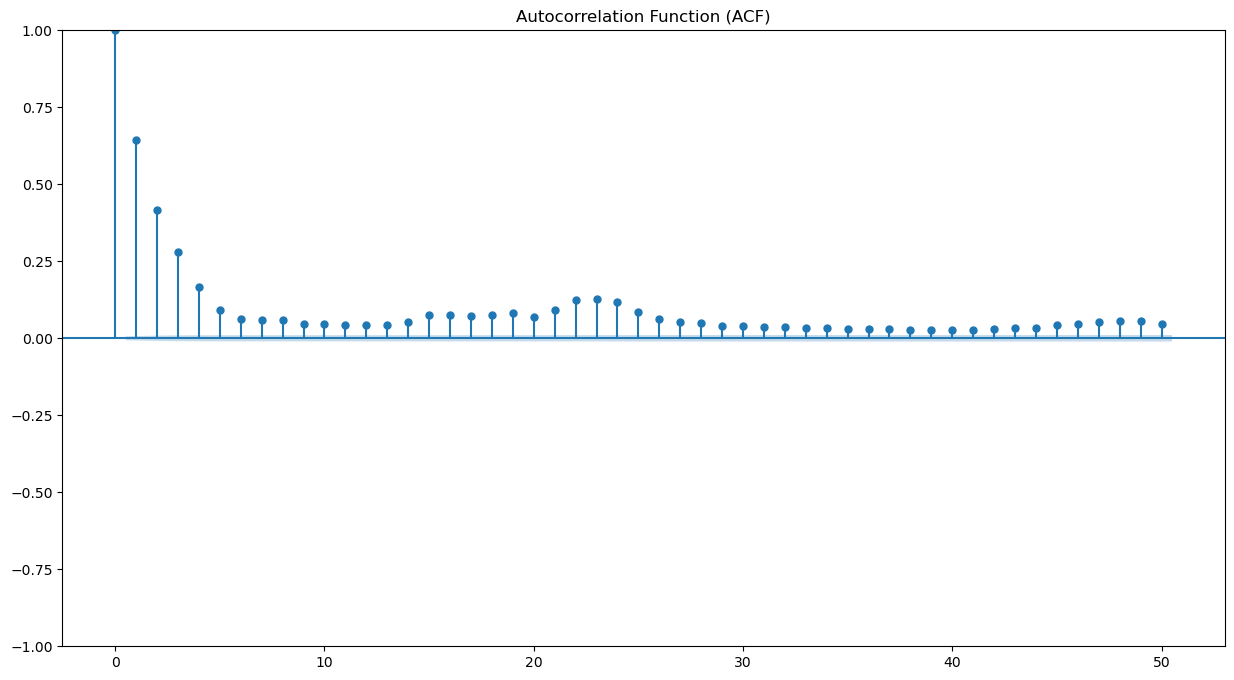

<Figure size 1200x600 with 0 Axes>

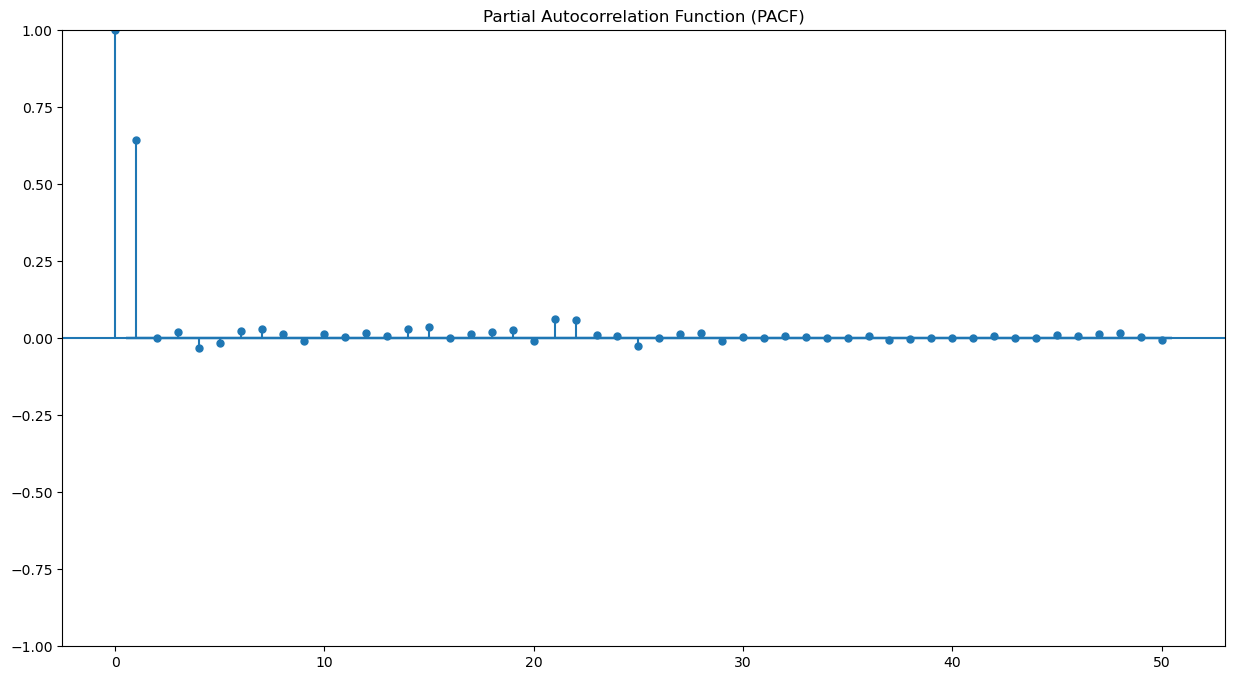

In [9]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Calculate ACF and PACF
acf_values = acf(df_explore['ElecPrice'])
pacf_values = pacf(df_explore['ElecPrice'])

# Plot ACF
plt.figure(figsize=(12, 6))
plot_acf(df_explore['ElecPrice'], title='Autocorrelation Function (ACF)')
plt.show()

# Plot PACF
plt.figure(figsize=(12, 6))
plot_pacf(df_explore['ElecPrice'], title='Partial Autocorrelation Function (PACF)')
plt.show()


Unfortunately, the AR and MA models are not easily distinguishable using the raw dataset. Let's continue by processing the data.

# Processing The Data

## Checking for missing values

Let's first check for any missing values in the dataset and return the count of missing values for each column. If there are any missing values, we can decide on an appropriate action such as removing rows with missing values or imputing the missing values. Fortunately, there are no missing values.

<Axes: title={'center': 'Percentage of missing values per feature'}, ylabel='Ratio of missing values per feature'>

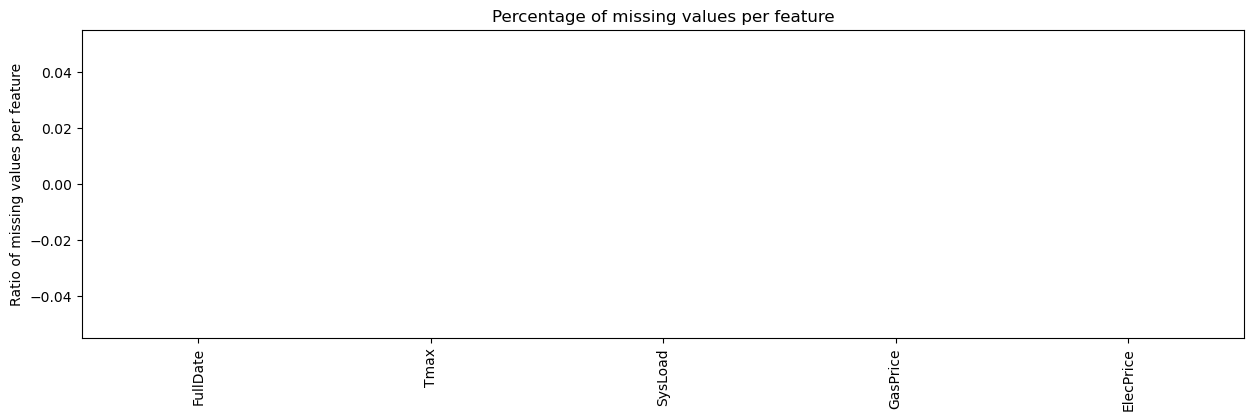

In [10]:
#Plot the ratio of missing values per feature

#Calculate the mean of missing values per feature
mean_missing = df.isna().mean().sort_values()

#Plot the mean missing values using a bar chart
plt.figure(figsize=(15, 4))
mean_missing.plot(kind="bar", title="Percentage of missing values per feature", ylabel="Ratio of missing values per feature")

**There are no missing values.**

## Checking for outliers

Let's visualize the ElecPrice column to see the outliers.

First, we display the boxplot of the ElecPrice column. Any values outside of the box are considered outliers.

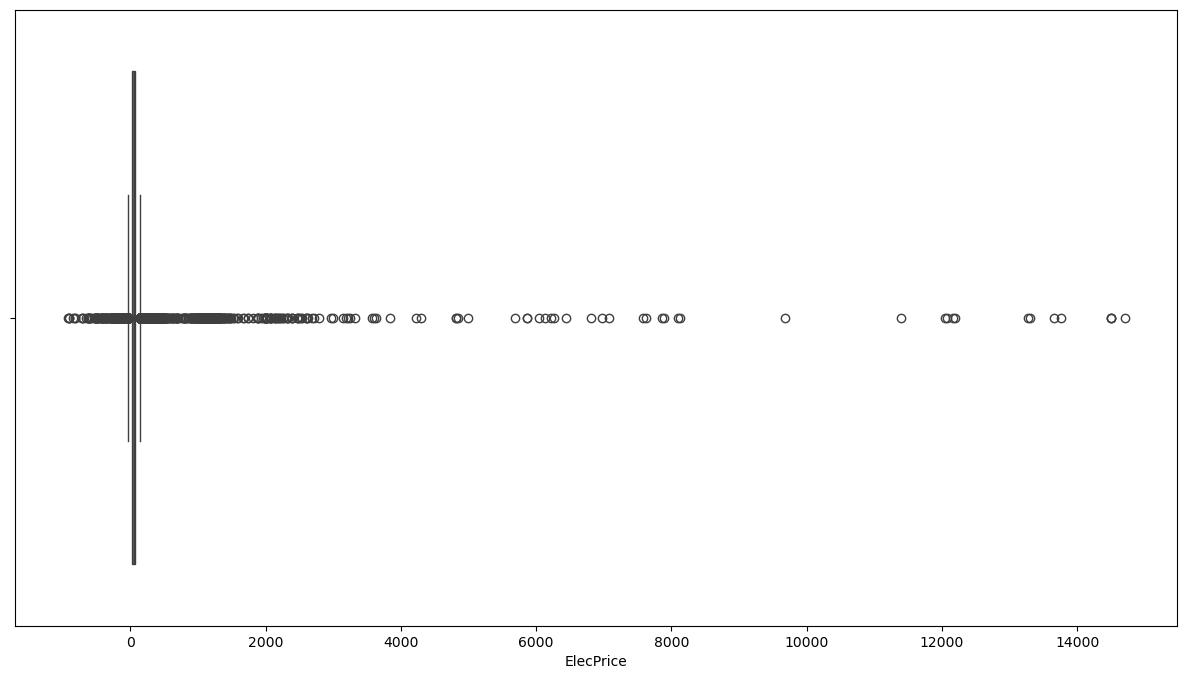

In [11]:
sns.boxplot(x=df['ElecPrice'])
plt.show()


To clearly understand the boxplot, we display a scatter plot, where any values that are far from the other values are considered outliers.

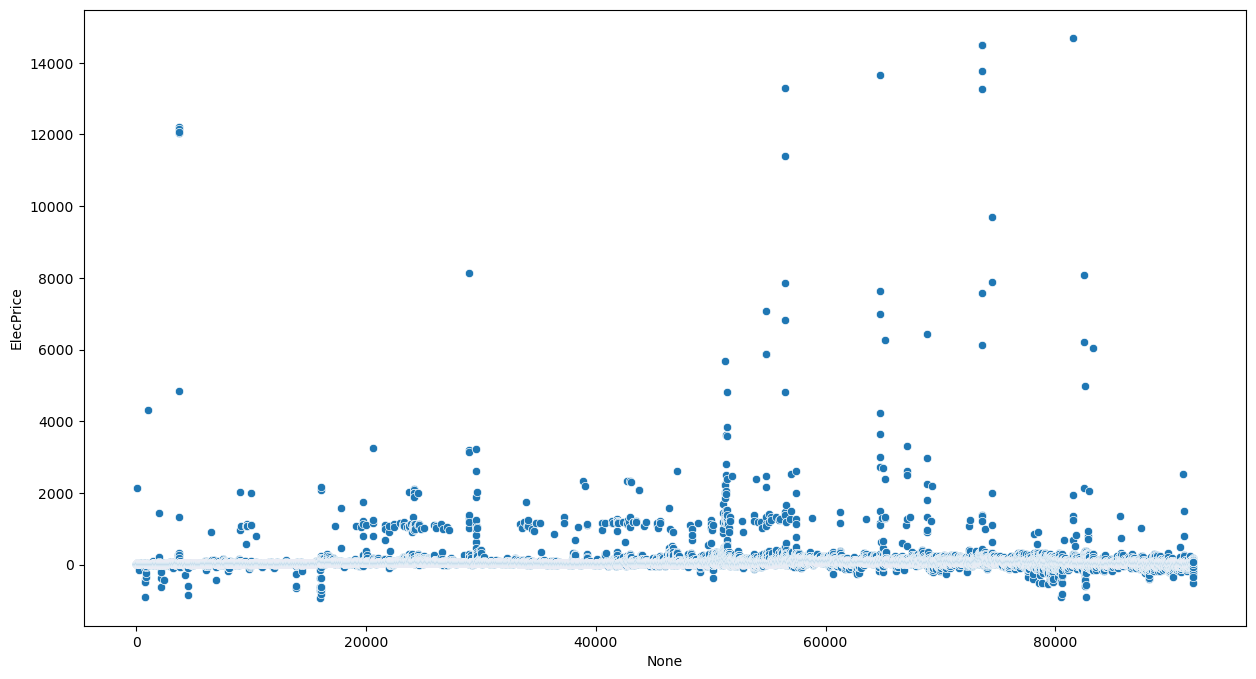

In [12]:
sns.scatterplot(x=df.index, y=df['ElecPrice'])
plt.show()

We see that there are a lot of outliers. We can clean these by removing rows where the ElecPrice values are outside of the 20th and 80th percentiles. Other options include replacing the outliers with the mean, median, or mode of the column or using a different method such as the Z-score to identify outliers. But for now, we will maintain the integrity of the data.


**The data is now cleaned, preprocessed and ready for modeling.**

# Modelling

We are now ready to move forward with building a model, testing its performance, and evaluating its results.

## Resampling the dataset to daily frequency

The purpose of resampling the data to a daily frequency is to make the time series data more manageable and easier to work with. By reducing the frequency, the data points are aggregated, making it easier to analyze patterns and trends. In using Prophet, the resampled data will be used to make accurate time series predictions by understanding the patterns in the data.

In [13]:
# Resample to daily frequency
df = df.resample('D', on='FullDate').sum()
df.head()

,Tmax,SysLoad,GasPrice,ElecPrice
FullDate,,,,
2010-09-01,379.2,41565.380,88.56,2751.700
2010-09-02,369.6,38898.990,88.56,570.810
2010-09-03,439.2,41665.760,106.80,504.975
2010-09-04,328.8,35638.085,81.36,502.275
2010-09-05,357.6,35611.410,106.80,500.555


In [14]:
df = df.reset_index()
df.head()

,FullDate,Tmax,SysLoad,GasPrice,ElecPrice
0,2010-09-01,379.2,41565.380,88.56,2751.700
1,2010-09-02,369.6,38898.990,88.56,570.810
2,2010-09-03,439.2,41665.760,106.80,504.975
3,2010-09-04,328.8,35638.085,81.36,502.275
4,2010-09-05,357.6,35611.410,106.80,500.555


## Preparing the data

Let's create a copy of the original data frame that only includes the 'FullDate' and 'ElecPrice' columns. The columns are then renamed to 'ds' and 'y', respectively, which are the required columns for Prophet's input data frame. The 'ds' column represents the date or time component of the series and the 'y' column represents the value component of the series. This step is necessary for formatting the data correctly to be used with Prophet.

In [15]:
# Create a copy of the dataframe with only two columns, FullDate and ElecPrice
df_1 = df[['FullDate', 'ElecPrice']].copy()

# Rename the columns to match the format required by Prophet
df_1.rename(columns={'FullDate': 'ds', 'ElecPrice': 'y'}, inplace=True)

We then split the data into train and test sets as instructed.

In [16]:
# Divide data into train and test sets
train = df_1[:2757]
test = df_1[2757:]



## Creating the model

Here, I am creating an instance of the Prophet model and then fitting it to the train set using the fit() function. The train set is passed as an argument to the fit() function and I am specifying the 'FullDate' and 'ElecPrice' columns as the columns to use for training the model. The 'FullDate' column is used as the 'ds' column and the 'ElecPrice' column is used as the 'y' column.

In [17]:
# Create and fit Prophet model
model = Prophet()
model.fit(train[['ds','y']])

10:48:05 - cmdstanpy - INFO - Chain [1] start processing
10:48:06 - cmdstanpy - INFO - Chain [1] done processing


# Making predictions

Now, we make predictions for the future based on the model created.

In [18]:
# Make predictions
future = model.make_future_dataframe(periods=len(test))
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper', 'trend', 'trend_lower', 'trend_upper']].tail()


,ds,yhat,yhat_lower,yhat_upper,trend,trend_lower,trend_upper
3829,2021-02-24,3447.267584,256.197394,6343.664793,3536.833676,1785.607669,5048.100029
3830,2021-02-25,3514.121063,510.771812,6360.208861,3537.627985,1783.958453,5050.544701
3831,2021-02-26,3280.918315,158.741853,6151.164561,3538.422295,1782.309236,5053.807313
3832,2021-02-27,2937.567622,-234.456639,5994.817021,3539.216605,1780.660020,5057.366946
3833,2021-02-28,2849.498777,-142.322336,5663.598401,3540.010914,1779.010803,5061.185180


The function "make_future_dataframe" is used to create a dataframe for the specified number of periods (in this case, the number of periods in the test set). 

The "predict" function is used to generate the predictions and the "yhat" column contains the predicted values. 

The "yhat_lower" and "yhat_upper" columns represent the lower and upper bounds of the prediction interval. 

The "trend" column represents the predicted trend and the "trend_lower" and "trend_upper" columns represent the lower and upper bounds of the trend. 

## Model evaluation

Let's evaluate the performance of the Prophet model by using two common metrics: Root Mean Squared Error (RMSE) and Mean Absolute Error (MAE). A lower value for RMSE and MAE indicates a better fit of the model to the data.

In [19]:
# Evaluate model performance
from sklearn.metrics import mean_squared_error, mean_absolute_error
predictions = forecast[2757:]['yhat'].values
test_set = test['y'].values

rmse = np.sqrt(mean_squared_error(test_set, predictions))
mae = mean_absolute_error(test_set, predictions)

print('Root Mean Squared Error:', rmse)
print('Mean Absolute Error:', mae)


Root Mean Squared Error: 3208.4823018736547
Mean Absolute Error: 1732.7313070219593


The figures shown here represent the best results obtained after cleaning and processing the data. Although, it is possible to further improve the results through hyperparameter tuning, it is outside the scope of this notebook.

## Forecast visualization

We can now observe the prediction results. The forecast aligns with our initial observations and insights from the data exploration. The future data points are confined within the range of the stationary series. The seasonal pattern is also clearly visible in the highs and lows of the trend.

c:\Users\Andreas\anaconda3\envs\esl\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\Andreas\anaconda3\envs\esl\Lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


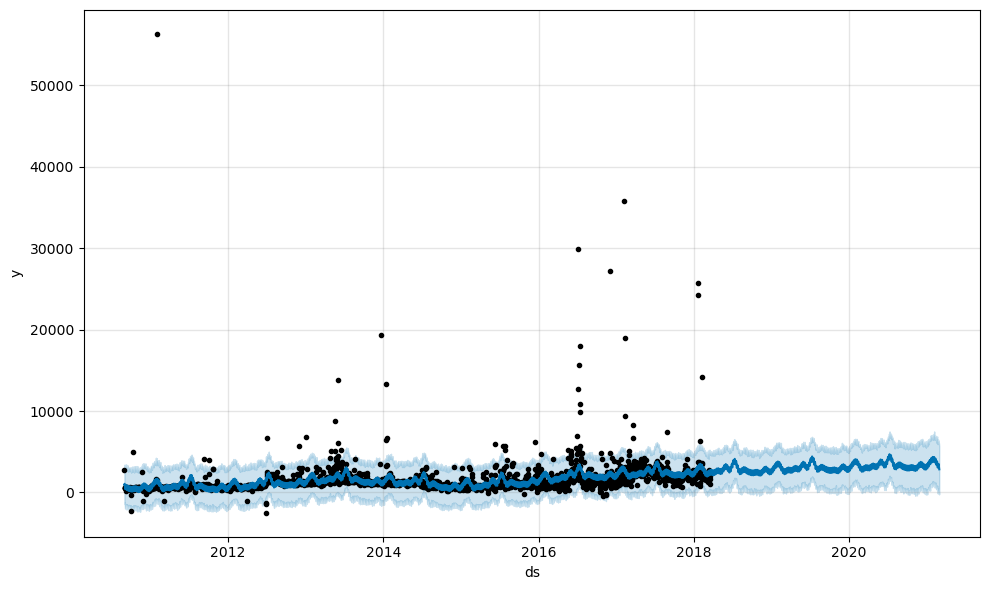

In [20]:
# Plot for the whole dataset

fig1 = model.plot(forecast)


c:\Users\Andreas\anaconda3\envs\esl\Lib\site-packages\prophet\plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\Andreas\anaconda3\envs\esl\Lib\site-packages\prophet\plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
c:\Users\Andreas\anaconda3\envs\esl\Lib\site-packages\prophet\plot.py:354: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To 

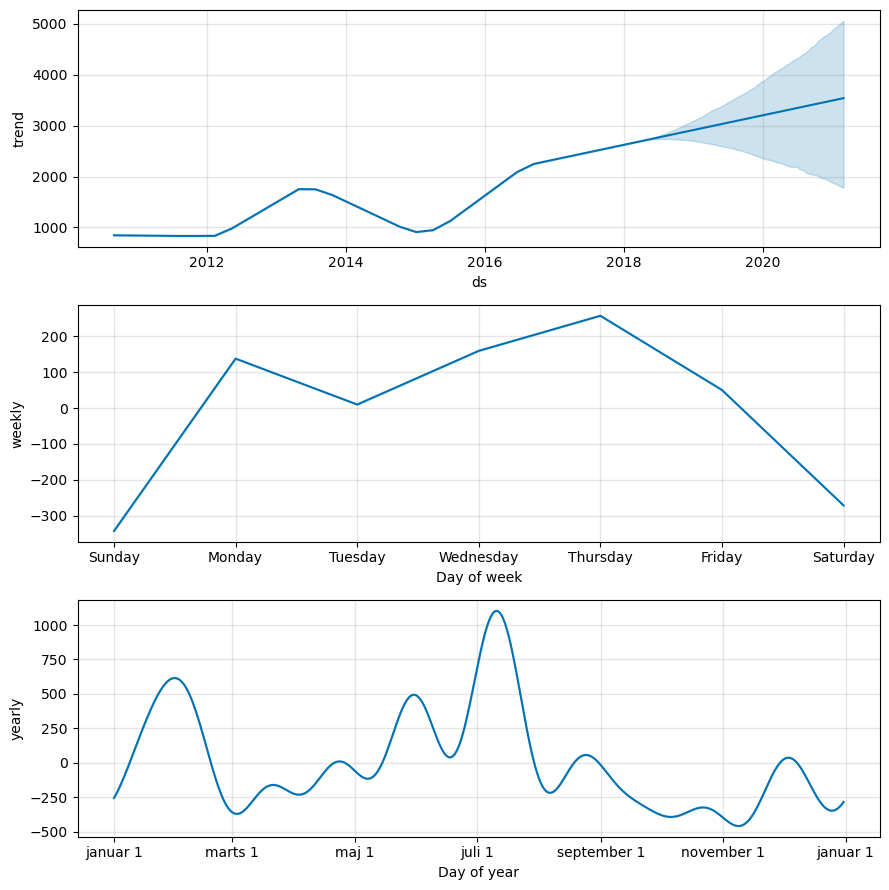

In [21]:
# Plot to see the components. Trend, weekly and yearly.

fig2 = model.plot_components(forecast)


In [22]:
# View the plot interactively

from prophet.plot import plot_plotly, plot_components_plotly

plot_plotly(model, forecast)

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'marker': {'color': 'black', 'size': 4},
              'mode': 'markers',
              'name': 'Actual',
              'type': 'scatter',
              'x': array([datetime.datetime(2010, 9, 1, 0, 0),
                          datetime.datetime(2010, 9, 2, 0, 0),
                          datetime.datetime(2010, 9, 3, 0, 0), ...,
                          datetime.datetime(2018, 3, 17, 0, 0),
                          datetime.datetime(2018, 3, 18, 0, 0),
                          datetime.datetime(2018, 3, 19, 0, 0)], shape=(2757,), dtype=object),
              'y': array([2751.7  ,  570.81 ,  504.975, ..., 1718.385, 1088.015, 1998.305],
                         shape=(2757,))},
             {'hoverinfo': 'skip',
              'line': {'width': 0},
              'mode': 'lines',
              'type': 'scatter',
              'x': array([datetime.datetime(2010, 9, 1, 0, 0),
                          datetime.datetime(2010, 9, 2, 0, 0),
                          datetime.datetime(2010, 9, 3, 0, 0), ...,
                          datetime.datetime(2021, 2, 26, 0, 0),
                          datetime.datetime(2021, 2, 27, 0, 0),
                          datetime.datetime(2021, 2, 28, 0, 0)], shape=(3834,), dtype=object),
              'y': array([-1408.45582228, -1217.335347  , -1615.32975892, ...,   158.74185285,
                           -234.45663906,  -142.32233562], shape=(3834,))},
             {'fill': 'tonexty',
              'fillcolor': 'rgba(0, 114, 178, 0.2)',
              'line': {'color': '#0072B2', 'width': 2},
              'mode': 'lines',
              'name': 'Predicted',
              'type': 'scatter',
              'x': array([datetime.datetime(2010, 9, 1, 0, 0),
                          datetime.datetime(2010, 9, 2, 0, 0),
                          datetime.datetime(2010, 9, 3, 0, 0), ...,
                          datetime.datetime(2021, 2, 26, 0, 0),
                          datetime.datetime(2021, 2, 27, 0, 0),
                          datetime.datetime(2021, 2, 28, 0, 0)], shape=(3834,), dtype=object),
              'y': array([ 989.01838174, 1069.30296417,  844.25091824, ..., 3280.91831501,
                          2937.56762191, 2849.49877742], shape=(3834,))},
             {'fill': 'tonexty',
              'fillcolor': 'rgba(0, 114, 178, 0.2)',
              'hoverinfo': 'skip',
              'line': {'width': 0},
              'mode': 'lines',
              'type': 'scatter',
              'x': array([datetime.datetime(2010, 9, 1, 0, 0),
                          datetime.datetime(2010, 9, 2, 0, 0),
                          datetime.datetime(2010, 9, 3, 0, 0), ...,
                          datetime.datetime(2021, 2, 26, 0, 0),
                          datetime.datetime(2021, 2, 27, 0, 0),
                          datetime.datetime(2021, 2, 28, 0, 0)], shape=(3834,), dtype=object),
              'y': array([3367.90198197, 3434.55197974, 3245.57272404, ..., 6151.16456069,
                          5994.81702136, 5663.59840134], shape=(3834,))}],
    'layout': {'height': 600,
               'showlegend': False,
               'template': '...',
               'width': 900,
               'xaxis': {'rangeselector': {'buttons': [{'count': 7, 'label': '1w', 'step': 'day', 'stepmode': 'backward'},
                                                       {'count': 1,
                                                        'label': '1m',
                                                        'step': 'month',
                                                        'stepmode': 'backward'},
                                                       {'count': 6,
                                                        'label': '6m',
                                                        'step': 'month',
                                                        'stepmode': 'backward'},
                                                       {'count': 1, 'label': '1y', 'step': 'year', 

# PART II. MULTIVARIATE TIME SERIES FORECASTING

# Introduction

In the first part, we used only the dependent variable (ElecPrice) and the time component for our modeling (ds vs y). Now, we will build a time series model using the other variables. These variables will be added to the forecast model as a regressor on Facebook Prophet. So the 3 independent variables [‘SysLoad’,’Tmax’,’GasPrice’'] will be [‘add1’, ‘add2’, ‘add3’’] as the regressors. Split the data into train and test as done above and build a multivariate forecast model to forecast the last x-2757 days of ElecPrice.

# Modelling

## Preparing the data

Let's get our data ready for multivariate time-series modeling by adding additional features Tmax, SysLoad, and GasPrice to the existing 'FullDate' and 'ElecPrice' features.

In [22]:
# Copy the original dataframe and rename columns
df_2 = df.copy()

# Rename columns for use in multivariate time-series modelling
df_2.rename(columns={'FullDate': 'ds', 'ElecPrice': 'y', 
                     'Tmax': 'add1', 'SysLoad': 'add2', 'GasPrice': 'add3'}, inplace=True)

In [23]:
# Divide data into train and test sets
train_2 = df_2[:2757]
test_2 = df_2[2757:]

## Training the model

In [24]:
# Initialize Prophet model with yearly, weekly, and daily seasonality
model_2 = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=True)

# Add additional regressors 'add1', 'add2', 'add3' to the model
model_2.add_regressor('add1')
model_2.add_regressor('add2')
model_2.add_regressor('add3')

# Fit the model with the training data including the date, target value 'y', and additional regressors
model_2.fit(train_2[['ds','y', 'add1', 'add2', 'add3']])

11:11:58 - cmdstanpy - INFO - Chain [1] start processing
11:11:58 - cmdstanpy - INFO - Chain [1] done processing


## Prediction

In [25]:
# Creating the future dataframe for prediction
future_2 = test_2.drop('y',axis=1)


In [26]:
# Predict future values with the multi-variate model
forecast_2 = model_2.predict(future_2)

# Show the predicted values for the specified features in the forecast dataframe
forecast_2[['ds', 'yhat', 'yhat_lower', 'yhat_upper', 'trend', 'trend_lower', 'trend_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper,trend,trend_lower,trend_upper
1072,2021-02-24,961.380036,-1285.253130,3242.505205,4011.368927,3250.223272,4718.130598
1073,2021-02-25,1320.712072,-989.133254,3598.164662,4012.059021,3249.813054,4718.644700
1074,2021-02-26,1384.297968,-914.345696,3669.067046,4012.749116,3249.163763,4720.175437
1075,2021-02-27,1039.222699,-1499.232374,3386.137335,4013.439211,3248.048788,4721.982679
1076,2021-02-28,1199.490332,-1119.201721,3460.391174,4014.129306,3246.933812,4723.789920


In [27]:
# Evaluate model performance

predictions_2 = forecast_2['yhat'].values
test_set_2 = test_2['y'].values

rmse = np.sqrt(mean_squared_error(test_set_2, predictions_2))
mae = mean_absolute_error(test_set_2, predictions_2)

print('Root Mean Squared Error:', rmse)
print('Mean Absolute Error:', mae)


Root Mean Squared Error: 2708.252203774175
Mean Absolute Error: 988.0591640566984


## Visualization

Now, we'll see how additional variables impact the prediction model and its outcomes.

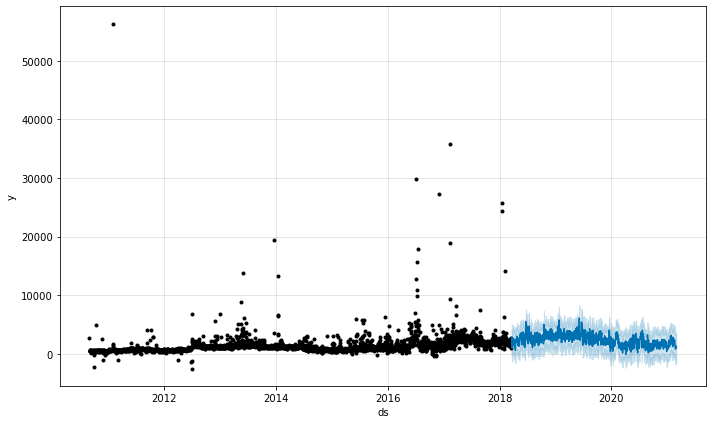

In [28]:
fig1_2 = model_2.plot(forecast_2)

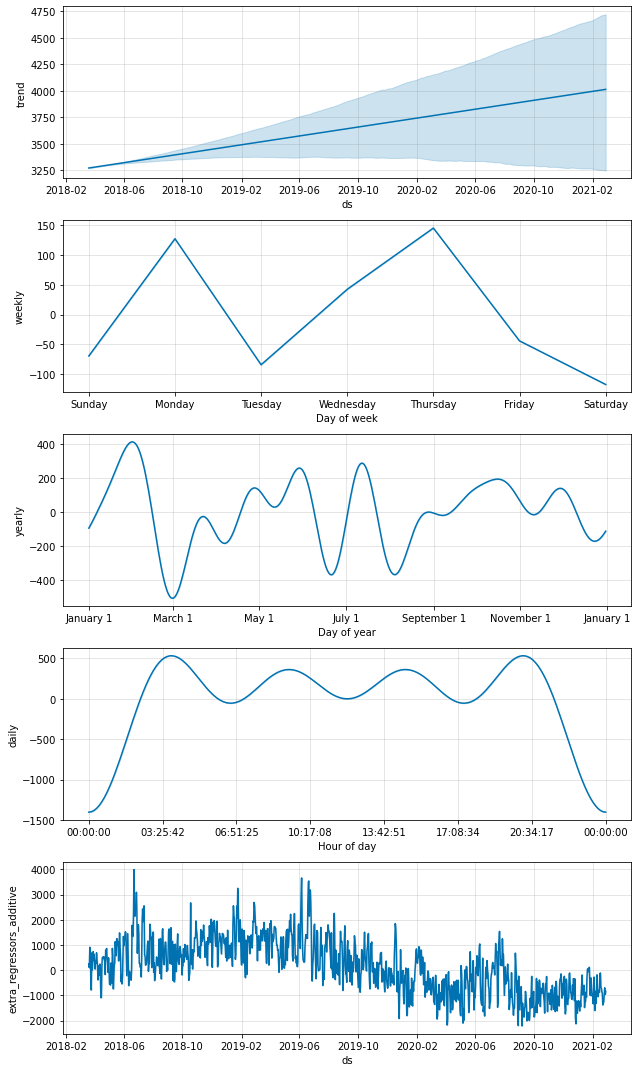

In [29]:
fig2_2 = model_2.plot_components(forecast_2)


In [30]:
plot_plotly(model_2, forecast_2)

# Conclusion

During our learning journey, we were delighted to uncover the incredible efficiency and simplicity of the prophet library for time series forecasting. We started by installing and importing the necessary tools and loading up our dataset. Then, we cleaned and prepared the data to optimize it for modeling.

We applied the prophet library to our preprocessed data and were pleasantly surprised at its accurate predictions. We also explored how other factors can impact the predictions through multivariate modeling.

We gained a solid understanding of time series modeling using the prophet library, which is both user-friendly and accessible for those with a basic knowledge of data science.

Now that we have a foundation, I encourage you to build on what we've learned by following along with my notebooks and practicing on your own datasets. Time series forecasting is a valuable skill in the world of data science, and I have no doubt that with practice, you will excel in it as well. Let's continue our learning and discover more exciting possibilities in this field together!

Please share your thoughts and feedback with us. I value and welcome your comments and insights. Your feedback helps me grow and improve as a data scientist, so don't hesitate to leave a comment below and let's engage in a productive and friendly discussion.